# Pituitary Referrals Data Analytics Notebook

This notebook contains some scripts for generating tables and insights based off the pituitary referrals data Dr. Catalino shared with me.

In [1]:
import os
import json
from itertools import combinations
from urllib.request import urlopen

import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import kruskal, mannwhitneyu
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Load & Clean Data

### Loading Data

In [2]:
raw_ref_data = pd.read_csv(os.path.join("data", "ref_data.csv"), index_col=0, encoding="ISO-8859-1")

In [3]:
raw_ref_data.head()

,Zip Code,Date of Initial Contact,Records Requested,Records Received,Films Requested,Films Received,Date of IV,Date of Surgery,RP Degree,RP Specialty,RP Address
Date of Birth,,,,,,,,,,,
17-Feb-93,33613,08-Oct-03,08-Oct-03,10-Oct-03,08-Oct-03,10-Oct-03,14-Nov-03,NaN,MD,NSR,"880 6th Street South, Suite 450 St Petersburg..."
02-Apr-70,22942,30-Oct-14,30-Oct-14,30-Oct-14,30-Oct-14,31-Oct-14,26-Nov-14,NaN,MD,PCP,NaN
05-Mar-87,22401,01-Jul-03,01-Jul-03,NaN,01-Jul-03,NaN,NaN,NaN,MD,GYN,"621 Jefferson Davis Highway, Suite 201 Freder..."
23-Jan-57,24472,13-Jan-14,13-Jan-14,NaN,13-Jan-14,NaN,NaN,NaN,MD,END,"55 Comfort Way, Suite 1 Lexington, VA 24450"
01-Dec-60,24504,14-Jul-15,NaN,14-Jul-15,NaN,13-Aug-15,NaN,NaN,MD,NSG,"2025 Tate Springs Road Lynchburg ,VA 24501"


### Clean Data

#### Start with Degree

There are 27 (after all being set to lowercase) unique names for degrees. Let's make a map for this.

In [4]:
referrers_degree = raw_ref_data["RP Degree"].apply(lambda x: str(x).lower()).unique()
len(referrers_degree), referrers_degree

(27,
 array(['md', 'nan', 'md, phd', 'do', 'np', 'fnp', 'pa-c', 'pa', 'fmd',
        'rn', 'aprn', 'm. d.', 'jr', 'md,facs', 'm.d.', 'phd',
        'dsc md frs', 'rnc', 'md\nmd', 'ph.d.', 'od', 'cnm', 'md, ph.d',
        'nc', 'md ph.d', 'n.p.', 'jr.'], dtype=object))

In [5]:
referrers_degree_map = {
    "md": "md/do",
    "md, phd": "md/do",
    "fmd": "md/do",
    "m. d.": "md/do",
    "md,facs": "md/do",
    "m.d.": "md/do",
    "md\\nmd": "md/do",
    "md, ph.d.": "md/do",
    "md ph.d": "md/do",
    "dsc md frs": "md/do",
    "do": "md/do",
    "od": "md/do",
    "nan": "nan",
    "np": "other",
    "fnp": "other",
    "n.p.": "other",
    "pa-c": "other",
    "pa": "other",
    "rn": "other",
    "aprn": "other",
    "rnc": "other",
    "nc": "other",
    "cnm": "other",
    "jr": "other",
    "jr.": "other",
}

# Now use the mapping and apply it to the column's lowercase values
referrers_degree = raw_ref_data["RP Degree"].apply(lambda x: str(x).lower()).map(referrers_degree_map)
# Turn nans into "nan"
referrers_degree = referrers_degree.fillna("nan")
# Check the unique values after mapping
referrers_degree.unique()


array(['md/do', 'nan', 'other'], dtype=object)

In [6]:
# Now we can replace the original column with the cleaned one
raw_ref_data["RP Degree"] = referrers_degree

#### Now Let's Clean Specialty

There is wayyyyy more of these.

In [7]:
# Start with seeing all the possible values of RP Specialty and RP Degree
referrers_spec = raw_ref_data["RP Specialty"].apply(lambda x: str(x).lower()).unique()
len(referrers_spec), referrers_spec

(193,
 array(['nsr', 'pcp', 'gyn', 'end', 'nsg', 'nan', 'neu', 'endo',
        'employer', 'dds', 'radiology-oncology', 'ref.', 'ref',
        'self/ref.', 'neuro surg', 'obs', 'int', 'opt', 'family physician',
        'onc', 'uro', 'fam med', 'ob', 'neurosurgeon', 'endocrinologist',
        'internist', 'general surgery', 'otolaryngologist', 'sur', 'peds',
        'endo.', 'ort', 'fmd', 'rad', 'ent', 'ped', 'attending', 'eye',
        'end/ref', 'ob/gyn', 'er', 'neuro/ref', 'distant relative/nsr',
        'family practice', 'psy', 'ob gyn', 'primary care', 'arthritis',
        'do', 'ref/pcp', "dau's pcp", 'neurologist', 'neuro-surg.', 'nsy',
        'neurology', 'endocrinology', 'surgeon', 'pcp/ref.', 'rad onc',
        'pul', 'opth', 'ped endo', 'genetics', 'neurosurgery',
        'neuro-surg,ref.,friend', 'internal medicine', 'nih', 'allergy',
        'family medicine', 'ref/endo', 'np', 'pain mgt', 'immunology',
        'endo/ref', 'cards', 'rheu', 'ophth', 'family medince', 'md',

In [8]:
specialty_to_category = {
    "Primary Care": [
        'pcp', 'primary care', 'family physician', 'fam med', 'family medicine',
        'fmd', 'family practice', 'fam medicine', 'fam practice', 'fp', 'gp',
        'general medicine', 'internal medicine', 'internal med', 'int',
        'int med', 'internist', 'im', 'student health', 'pcp at facility',
        'int.', 'internal med.', 'general', 'ref/pcp', 'ref./pcp',
        'pcp/ref.', 'pcp/ref', 'ref/int', 'ref/int./pcp', "dau's pcp", 'student health', 'inter',
        'int/ref', 'old pcp/ref'
    ],
    "Endocrinology": [
        'end', 'endo', 'endocrinologist', 'endocrinology', 'endocronolgist',
        'endocinolgist', 'endocrinolgist', 'endo/internal medicine',
        'internal medicine/endo', 'endo/ref', 'ref/endo', 'endo/ref.', 'end./ref.',
        'ref./endo.', 'endo./ref.', 'end fellow', 'ref/end', 'ref./endo.', 'end/ref.'
    ],
    "Neurology": [
        'neu', 'neurologist', 'neurology', 'neurologists', 'neurgologist',
        'neuro', 'neuro/ref', 'neuro-onco', 'neur'
    ],
    "Neurosurgery": [
        'nsg', 'nsy', 'neuro surg', 'neurosurgeon', 'neurosurgery', 
        'neuro-surg.', 'neuro-surg,ref.,friend', 'neurosurg/ref', 'neurosurg.', 
        'nsgy', 'mj neurosciences', 'nero-surg', 'neuro-sergon', 'nrs', 'mj neurosciences', 
        'nrs', 'nsr'
    ],
    "Surgery": [
        'sur', 'surgeon', 'general surgery', 'oral surgery'
    ],
    "OB/GYN": [
        'gyn', 'ob', 'ob gyn', 'obgyn', 'ob/gyn', 'ob/gyn & ref',
        'ob/ gyn', 'ob/ref', 'gyn/pcp', 'gynecology'
    ],
    "Oncology": [
        'onc', 'hem onc', 'oncology', 'rad onc', 'radiology-oncology',
        'roc', 'rad oncology', 'rad on', 'oco'
    ],
    "Radiology": [
        'rad', 'rad on', 'rad onc', 'radiology-oncology'
    ],
    "Orthopedics": [
        'ort', 'ortho', 'orth', 'sports & spine'
    ],
    "Ophthalmology": [
        'opt', 'ophth', 'opth', 'optho', 'opthalmology', 'opthamologist'
    ],
    "Pediatrics": [
        'peds', 'ped', 'pediatrics', 'ped endo', 'peds endo', 'ped/end',
        'peds card', 'ped/pcp', 'ped end'
    ],
    "Urology": [
        'uro', 'uro/ref', 'urology', 'uro./ref', 'andrology'
    ],
    "Cardiology": [
        'car', 'card', 'cardiac', 'cardiologist', 'car/pcp'
    ],
    "ENT": [
        'ent', 'oto', 'ent/ref', 'otolaryngologist', 'oto-hns', 'ot/ref.'
    ],
    "Rheumatology": [
        'rheu', 'rhe', 'rhem'
    ],
    "Psychiatry": [
        'psy', 'psych'
    ],
    "Pulmonology": [
        'pul'
    ],
    "Nephrology": [
        'neph', 'nephrology', 'nep'
    ],
    "Allergy/Immunology": [
        'allergy', 'immunology'
    ],
    "Pain Management": [
        'pain', 'pain mgt'
    ],
    "Hospital Medicine": [
        'attending', 'hospitalist', 'hosp'
    ],
    "Emergency Medicine": [
        'er', 'er physician', 'emd', 'ems'
    ],
    "Genetics": [
        'genetics'
    ],
    "Infectious Disease": [
        'id'
    ],
    "GI / Digestive Health": [
        'gi/dig health'
    ],
    "Rehabilitation": [
        'pmr'
    ],
    "Endoscopy": [
        'end/ref'
    ],
    "Other / Unclassified": [
        'nan', 'self/ref.', 'ref.', 'ref',  'ref/',
        'distant relative/nsr', 'midlife', 'epid', 'fellow', 'md', 'ref./', 'pts niece',
    ]
}


# Create a mapping dictionary for the specialties to their categories
specialty_to_category_map = {}
for category, specialties in specialty_to_category.items():
    for specialty in specialties:
        specialty_to_category_map[specialty] = category
# Now use the mapping and apply it to the column's lowercase values
referrers_spec = raw_ref_data["RP Specialty"].apply(lambda x: str(x).lower()).map(specialty_to_category_map)
# Turn nans into "nan"
referrers_spec = referrers_spec.fillna("nan")
# Check the unique values after mapping
referrers_spec.unique()

array(['Neurosurgery', 'Primary Care', 'OB/GYN', 'Endocrinology',
       'Other / Unclassified', 'Neurology', 'nan', 'Radiology',
       'Ophthalmology', 'Oncology', 'Urology', 'Surgery', 'ENT',
       'Pediatrics', 'Orthopedics', 'Hospital Medicine', 'Endoscopy',
       'Emergency Medicine', 'Psychiatry', 'Pulmonology', 'Genetics',
       'Allergy/Immunology', 'Pain Management', 'Rheumatology',
       'Nephrology', 'Rehabilitation', 'Cardiology', 'Infectious Disease',
       'GI / Digestive Health'], dtype=object)

In [9]:
# Now we can replace the original column with the cleaned one
raw_ref_data["RP Specialty"] = referrers_spec

In [10]:
raw_ref_data.head(5)

,Zip Code,Date of Initial Contact,Records Requested,Records Received,Films Requested,Films Received,Date of IV,Date of Surgery,RP Degree,RP Specialty,RP Address
Date of Birth,,,,,,,,,,,
17-Feb-93,33613,08-Oct-03,08-Oct-03,10-Oct-03,08-Oct-03,10-Oct-03,14-Nov-03,NaN,md/do,Neurosurgery,"880 6th Street South, Suite 450 St Petersburg..."
02-Apr-70,22942,30-Oct-14,30-Oct-14,30-Oct-14,30-Oct-14,31-Oct-14,26-Nov-14,NaN,md/do,Primary Care,NaN
05-Mar-87,22401,01-Jul-03,01-Jul-03,NaN,01-Jul-03,NaN,NaN,NaN,md/do,OB/GYN,"621 Jefferson Davis Highway, Suite 201 Freder..."
23-Jan-57,24472,13-Jan-14,13-Jan-14,NaN,13-Jan-14,NaN,NaN,NaN,md/do,Endocrinology,"55 Comfort Way, Suite 1 Lexington, VA 24450"
01-Dec-60,24504,14-Jul-15,NaN,14-Jul-15,NaN,13-Aug-15,NaN,NaN,md/do,Neurosurgery,"2025 Tate Springs Road Lynchburg ,VA 24501"


#### Do the same for zip code 

In [11]:
# See the unique values of Zip Code
zips = raw_ref_data["Zip Code"].unique()

# See that all the zips are 5 digits long, if not try to resolve this
def clean_zip(zip):
    """
    Clean the zip code to ensure it's a 5-digit number.

    Args:
        zip (str or int): The zip code to clean.

    Returns:
        str: The cleaned zip code. 'nan' if the zip code is not valid.
    """
    if len(str(zip)) != 5:
        # If it contains a dash, split it and take the first part
        if "-" in str(zip):
            zip = str(zip).split("-")[0]
            # Check if it's 5 digits now
            if len(zip) != 5:
                print(f"Zip code {zip} is not 5 digits long after splitting.")
                return "nan"
        else:
            print(f"Zip code {zip} is not 5 digits long.")
            return "nan"
        
        # If it's np.nan, return 'nan'
    if pd.isna(zip):
        return "nan"
    return str(zip)

# Apply the function to the Zip Code column
raw_ref_data["Zip Code"] = raw_ref_data["Zip Code"].apply(clean_zip)

Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code ISRAEL is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code H3W 1P4 is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code V6G 3G4 is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code nan is not 5 digits long.
Zip code 

## Analytics

Worth noting that normality tests were done (shapiro) and most of our data when split up is overwhelmingly not normally distributed.

In [12]:
# Function to get the difference in time between two dates
def get_time_difference(start_date, end_date):
    """
    Calculate the difference in days between two dates.
    Handles NaN values by returning NaN if either date is NaN. Otherwise if a date is not in the correct format, it returns NaN.

    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        int: The difference in days between the two dates.
    """
    
    # Check if either date is NaN
    if pd.isna(start_date) or pd.isna(end_date):
        return np.nan
    
    # Check if the dates are in the correct format
    if not isinstance(start_date, str) or not isinstance(end_date, str):
        return np.nan
    
    # Check if the dates are in the correct format of 08-Oct-03	
    try:
        start_date = pd.to_datetime(start_date, format='%d-%b-%y')
        end_date = pd.to_datetime(end_date, format='%d-%b-%y')
    except ValueError:
        return np.nan
    
    # Convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Calculate the difference
    time_diff = end_date - start_date
    
    # Return the difference in days
    return time_diff.days

# Apply the function to the DataFrame, get the time between Records Requested and Records Received, Films Requested and Films Received, Date of Initial Contact and Date of IV, and Date of Initial Contact and Date of Surgery
raw_ref_data["Days between Records Requested and Received"] = raw_ref_data.apply(
    lambda row: get_time_difference(row["Records Requested"], row["Records Received"]), axis=1
)
raw_ref_data["Days between Films Requested and Received"] = raw_ref_data.apply(
    lambda row: get_time_difference(row["Films Requested"], row["Films Received"]), axis=1
)
raw_ref_data["Days between Initial Contact and IV"] = raw_ref_data.apply(
    lambda row: get_time_difference(row["Date of Initial Contact"], row["Date of IV"]), axis=1
)
raw_ref_data["Days between Initial Contact and Surgery"] = raw_ref_data.apply(
    lambda row: get_time_difference(row["Date of Initial Contact"], row["Date of Surgery"]), axis=1
)


In [13]:
raw_ref_data.head()

,Zip Code,Date of Initial Contact,Records Requested,Records Received,Films Requested,Films Received,Date of IV,Date of Surgery,RP Degree,RP Specialty,RP Address,Days between Records Requested and Received,Days between Films Requested and Received,Days between Initial Contact and IV,Days between Initial Contact and Surgery
Date of Birth,,,,,,,,,,,,,,,
17-Feb-93,33613,08-Oct-03,08-Oct-03,10-Oct-03,08-Oct-03,10-Oct-03,14-Nov-03,NaN,md/do,Neurosurgery,"880 6th Street South, Suite 450 St Petersburg...",2.0,2.0,37.0,NaN
02-Apr-70,22942,30-Oct-14,30-Oct-14,30-Oct-14,30-Oct-14,31-Oct-14,26-Nov-14,NaN,md/do,Primary Care,NaN,0.0,1.0,27.0,NaN
05-Mar-87,22401,01-Jul-03,01-Jul-03,NaN,01-Jul-03,NaN,NaN,NaN,md/do,OB/GYN,"621 Jefferson Davis Highway, Suite 201 Freder...",NaN,NaN,NaN,NaN
23-Jan-57,24472,13-Jan-14,13-Jan-14,NaN,13-Jan-14,NaN,NaN,NaN,md/do,Endocrinology,"55 Comfort Way, Suite 1 Lexington, VA 24450",NaN,NaN,NaN,NaN
01-Dec-60,24504,14-Jul-15,NaN,14-Jul-15,NaN,13-Aug-15,NaN,NaN,md/do,Neurosurgery,"2025 Tate Springs Road Lynchburg ,VA 24501",NaN,NaN,NaN,NaN


In [14]:
# Define a custom IQR function
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

# Columns to summarize
cols = [
    "Days between Records Requested and Received",
    "Days between Films Requested and Received",
    "Days between Initial Contact and IV",
    "Days between Initial Contact and Surgery"
]

# Compute overall stats
referrers_stats = pd.DataFrame({
    "Metric": ["median", "Q1", "Q3", "IQR"],
})

for col in cols:
    referrers_stats[col] = [
        raw_ref_data[col].median(),
        raw_ref_data[col].quantile(0.25),
        raw_ref_data[col].quantile(0.75),
        iqr(raw_ref_data[col])
    ]

# Round results
referrers_stats = referrers_stats.round(2)

# Display
referrers_stats


,Metric,Days between Records Requested and Received,Days between Films Requested and Received,Days between Initial Contact and IV,Days between Initial Contact and Surgery
0,median,4.0,7.0,44.0,45.0
1,Q1,1.0,4.0,28.0,29.0
2,Q3,11.0,15.0,64.0,65.0
3,IQR,10.0,11.0,36.0,36.0


In [15]:
# Create a map for the medians of each column
referrers_medians = raw_ref_data[cols].median().to_dict()


C:\Users\15406\AppData\Local\Temp\ipykernel_18644\2001266141.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Median: {medians[i]:.0f}\nIQR: {referrers_stats.loc[3, metrics[i]]:.0f}',


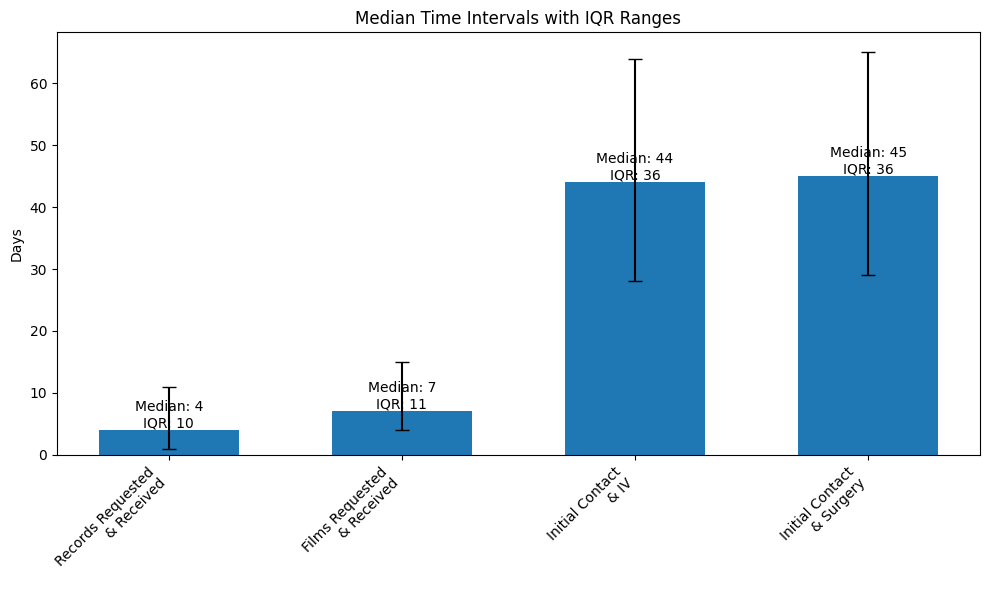

In [16]:
# Plot referrers data medians with error bars for IQR from Q1 to Q3
plt.figure(figsize=(10, 6))

# Data preparation
metrics = referrers_stats.columns[1:].tolist()  # Skip 'Metric' column
medians = referrers_stats.loc[0, metrics]  # Get median values
q1 = referrers_stats.loc[1, metrics]  # Get Q1 values
q3 = referrers_stats.loc[2, metrics]  # Get Q3 values

# Calculate error bar lengths
yerr = np.array([medians - q1, q3 - medians])

# Create bar plot
x = np.arange(len(metrics))
bars = plt.bar(x, medians, width=0.6)

# Add error bars
plt.errorbar(x, medians, yerr=yerr, fmt='none', color='black', capsize=5)

# Customize the plot
plt.xticks(x, [m.replace('Days between ', '').replace(' and', '\n&') for m in metrics], 
           rotation=45, ha='right')
plt.ylabel('Days')
plt.title('Median Time Intervals with IQR Ranges')

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'Median: {medians[i]:.0f}\nIQR: {referrers_stats.loc[3, metrics[i]]:.0f}',
             ha='center', va='bottom')

# Adjust layout to prevent label clipping
plt.tight_layout()

# Save to plots directory
plt.savefig(os.path.join("plots", "referrers_medians.png"), dpi=300)

plt.show()

### Referring Physician Degree

In [17]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

# Aggregation dictionary with Q1 and Q3 added
agg_funcs = {}
for col in cols:
    agg_funcs[col] = ["median", q1, q3, iqr]

# Compute statistics
referrers_degree_stats = raw_ref_data.groupby("RP Degree").agg(agg_funcs).reset_index()

# Flatten column names
referrers_degree_stats.columns = ['RP Degree'] + [
    f"{col} {stat.__name__.capitalize() if callable(stat) else stat.capitalize()}".strip()
    for col, stat in referrers_degree_stats.columns[1:]
]

# Round results
referrers_degree_stats = referrers_degree_stats.round(2)

# Add number of records
referrers_degree_stats["Number of Records"] = raw_ref_data.groupby("RP Degree").size().values

# Sort by count
referrers_degree_stats = referrers_degree_stats.sort_values(by="Number of Records", ascending=False)

# Optional: rename RP Degree to something cleaner
referrers_degree_stats = referrers_degree_stats.rename(columns={"RP Degree": "Referrer Degree"})

# Display the first few rows
referrers_degree_stats.head()

,Referrer Degree,Days between Records Requested and Received Median,Days between Records Requested and Received Q1,Days between Records Requested and Received Q3,Days between Records Requested and Received Iqr,Days between Films Requested and Received Median,Days between Films Requested and Received Q1,Days between Films Requested and Received Q3,Days between Films Requested and Received Iqr,Days between Initial Contact and IV Median,Days between Initial Contact and IV Q1,Days between Initial Contact and IV Q3,Days between Initial Contact and IV Iqr,Days between Initial Contact and Surgery Median,Days between Initial Contact and Surgery Q1,Days between Initial Contact and Surgery Q3,Days between Initial Contact and Surgery Iqr,Number of Records
0,md/do,4.0,1.0,11.0,10.0,7.0,4.00,14.0,10.00,45.0,28.0,64.0,36.0,45.0,28.25,65.00,36.75,4351
1,nan,5.0,1.0,15.0,14.0,8.0,5.00,19.0,14.00,46.0,30.0,72.0,42.0,59.5,37.50,72.75,35.25,921
2,other,2.0,0.0,8.0,8.0,5.0,1.75,9.5,7.75,36.5,20.0,49.5,29.5,52.0,32.50,75.50,43.00,132


Almost false across the board (as it is in future sections), so proceeding on doing testing and vis with medians and IQR. If statistically significant let's do a Mann-Whitney U test.

In [18]:
# Grouping column
group_col = "RP Degree"
value_cols = [
    "Days between Records Requested and Received",
    "Days between Films Requested and Received",
    "Days between Initial Contact and IV",
    "Days between Initial Contact and Surgery"
]
for value_col in value_cols:
    # Fill NaNs in RP Degree with "nan" for grouping
    raw_ref_data[group_col] = raw_ref_data[group_col].fillna("nan")

    # Get data for each group
    groups = raw_ref_data[group_col].unique()
    samples = [raw_ref_data[raw_ref_data[group_col] == g][value_col].dropna() for g in groups]

    # Run Kruskal–Wallis test
    stat, p = kruskal(*samples)

    # Print results
    print(f"\nKruskal–Wallis test for {value_col}:")
    print(f"Groups: {groups}")
    print(f"Kruskal–Wallis H = {stat:.3f}, p-value = {p:.4f}")

    # If Kruskal-Wallis is significant, perform pairwise Mann-Whitney U tests
    if p < 0.05:
        print(f"Performing pairwise Mann-Whitney U tests for {value_col}...")
        for g1, g2 in combinations(groups, 2):
            s1 = raw_ref_data[raw_ref_data[group_col] == g1][value_col].dropna()
            s2 = raw_ref_data[raw_ref_data[group_col] == g2][value_col].dropna()
            stat, p = mannwhitneyu(s1, s2, alternative="two-sided")
            print(f"{g1} vs {g2}: U={stat:.2f}, p={p:.4f}")


Kruskal–Wallis test for Days between Records Requested and Received:
Groups: ['md/do' 'nan' 'other']
Kruskal–Wallis H = 9.184, p-value = 0.0101
Performing pairwise Mann-Whitney U tests for Days between Records Requested and Received...
md/do vs nan: U=264476.50, p=0.4865
md/do vs other: U=108520.00, p=0.0031
nan vs other: U=9624.00, p=0.0105

Kruskal–Wallis test for Days between Films Requested and Received:
Groups: ['md/do' 'nan' 'other']
Kruskal–Wallis H = 14.819, p-value = 0.0006
Performing pairwise Mann-Whitney U tests for Days between Films Requested and Received...
md/do vs nan: U=203348.50, p=0.0248
md/do vs other: U=92375.50, p=0.0022
nan vs other: U=7914.00, p=0.0004

Kruskal–Wallis test for Days between Initial Contact and IV:
Groups: ['md/do' 'nan' 'other']
Kruskal–Wallis H = 9.251, p-value = 0.0098
Performing pairwise Mann-Whitney U tests for Days between Initial Contact and IV...
md/do vs nan: U=181993.00, p=0.0922
md/do vs other: U=87419.00, p=0.0132
nan vs other: U=6065

Interestingly, seems like there are significant differences between MD/DO and other across those 3, where being in the "other" category generally results in faster turnover rates.

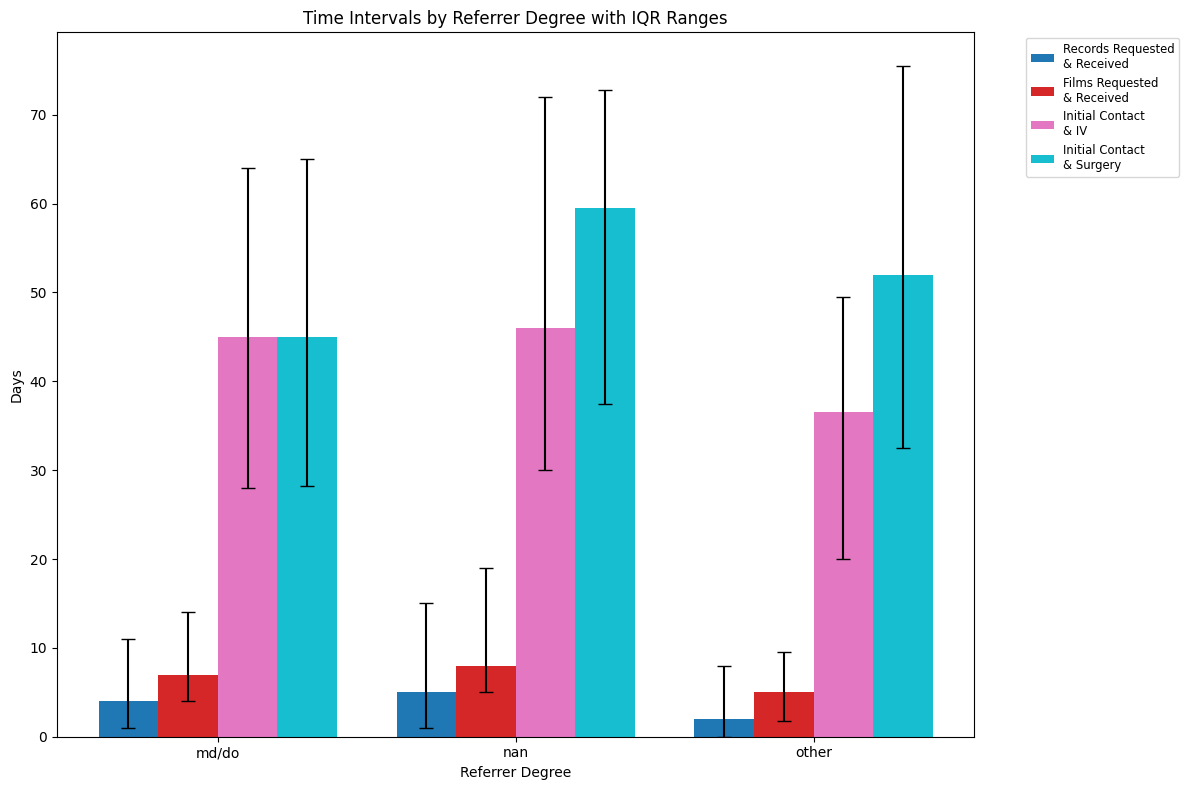

In [19]:
# Make a plot of the referrers degree stats
plt.figure(figsize=(12, 8))

# Get the categories and metrics
categories = referrers_degree_stats['Referrer Degree']
metrics = [
    'Days between Records Requested and Received',
    'Days between Films Requested and Received',
    'Days between Initial Contact and IV',
    'Days between Initial Contact and Surgery'
]

# Set up the bar positions
x = np.arange(len(categories))
n_metrics = len(metrics)
bar_width = 0.8 / n_metrics
colors = plt.cm.tab10(np.linspace(0, 1, n_metrics))

# Plot bars and error bars for each metric
for i, metric in enumerate(metrics):
    # Get the data
    medians = referrers_degree_stats[f'{metric} Median']
    q1 = referrers_degree_stats[f'{metric} Q1']
    q3 = referrers_degree_stats[f'{metric} Q3']
    
    # Calculate bar positions
    bar_pos = x + (i * bar_width) - (bar_width * (n_metrics-1)/2)
    
    # Create bars
    bars = plt.bar(bar_pos, 
                   medians,
                   width=bar_width,
                   label=metric.replace('Days between ', '').replace(' and', '\n&'),
                   color=colors[i])
    
    # Add error bars
    plt.errorbar(bar_pos,
                 medians,
                 yerr=[medians - q1, q3 - medians],
                 fmt='none',
                 color='black',
                 capsize=5)

# Customize the plot
plt.xlabel('Referrer Degree')
plt.ylabel('Days')
plt.title('Time Intervals by Referrer Degree with IQR Ranges')
plt.xticks(x, categories)

# Add legend with smaller font and move it outside
plt.legend(bbox_to_anchor=(1.05, 1),
          loc='upper left',
          fontsize='small')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Save to plots directory
plt.savefig(os.path.join("plots", "referrers_degree_stats.png"), dpi=300)

plt.show()


### Referral Specialty

In [20]:
# Compute grouped stats
referrers_spec_stats = raw_ref_data.groupby("RP Specialty").agg(agg_funcs).reset_index()

# Flatten multiindex columns
referrers_spec_stats.columns = ['RP Specialty'] + [
    f"{col} {stat.__name__.capitalize() if callable(stat) else stat.capitalize()}".strip()
    for col, stat in referrers_spec_stats.columns[1:]
]

# Round results
referrers_spec_stats = referrers_spec_stats.round(2)

# Add record counts
referrers_spec_stats["Number of Records"] = raw_ref_data.groupby("RP Specialty").size().values

# Rename for clarity
referrers_spec_stats = referrers_spec_stats.rename(columns={"RP Specialty": "Referrer Specialty"})

# Sort by number of records
referrers_spec_stats = referrers_spec_stats.sort_values(by="Number of Records", ascending=False)

# Display the top specialties
referrers_spec_stats.head(20)


,Referrer Specialty,Days between Records Requested and Received Median,Days between Records Requested and Received Q1,Days between Records Requested and Received Q3,Days between Records Requested and Received Iqr,Days between Films Requested and Received Median,Days between Films Requested and Received Q1,Days between Films Requested and Received Q3,Days between Films Requested and Received Iqr,Days between Initial Contact and IV Median,Days between Initial Contact and IV Q1,Days between Initial Contact and IV Q3,Days between Initial Contact and IV Iqr,Days between Initial Contact and Surgery Median,Days between Initial Contact and Surgery Q1,Days between Initial Contact and Surgery Q3,Days between Initial Contact and Surgery Iqr,Number of Records
4,Endocrinology,5.0,1.0,13.00,12.00,9.0,5.00,17.00,12.00,51.0,34.00,71.00,37.00,50.0,35.0,69.00,34.00,1973
20,Primary Care,3.0,1.0,8.00,7.00,6.0,2.00,11.75,9.75,41.0,24.00,58.00,34.00,38.0,17.0,56.50,39.50,1160
17,Other / Unclassified,4.0,1.0,14.00,13.00,8.0,4.00,18.00,14.00,47.0,28.00,72.00,44.00,59.5,31.5,81.25,49.75,964
12,Neurosurgery,5.0,1.0,9.00,8.00,7.0,3.00,14.00,11.00,40.0,22.25,61.75,39.50,41.0,25.0,52.75,27.75,455
11,Neurology,4.0,1.0,12.00,11.00,6.0,3.00,13.00,10.00,42.0,22.00,62.00,40.00,44.0,26.5,61.25,34.75,300
15,Ophthalmology,3.0,1.0,8.00,7.00,6.0,3.00,9.25,6.25,23.0,12.50,37.00,24.50,32.0,20.0,41.00,21.00,113
28,nan,1.5,0.0,7.00,7.00,6.0,1.75,11.25,9.50,30.0,18.00,58.50,40.50,52.0,36.5,67.50,31.00,90
13,OB/GYN,3.0,1.0,11.00,10.00,7.0,3.00,18.25,15.25,47.5,35.50,55.00,19.50,55.0,55.0,55.00,0.00,81
2,ENT,2.0,1.0,4.50,3.50,3.0,2.00,6.50,4.50,34.0,26.00,47.50,21.50,22.0,18.0,26.00,8.00,46
27,Urology,2.0,1.0,4.00,3.00,3.0,1.00,9.00,8.00,41.0,26.75,52.25,25.50,34.0,34.0,34.00,0.00,45


Plot the data for top 10 median with IQR

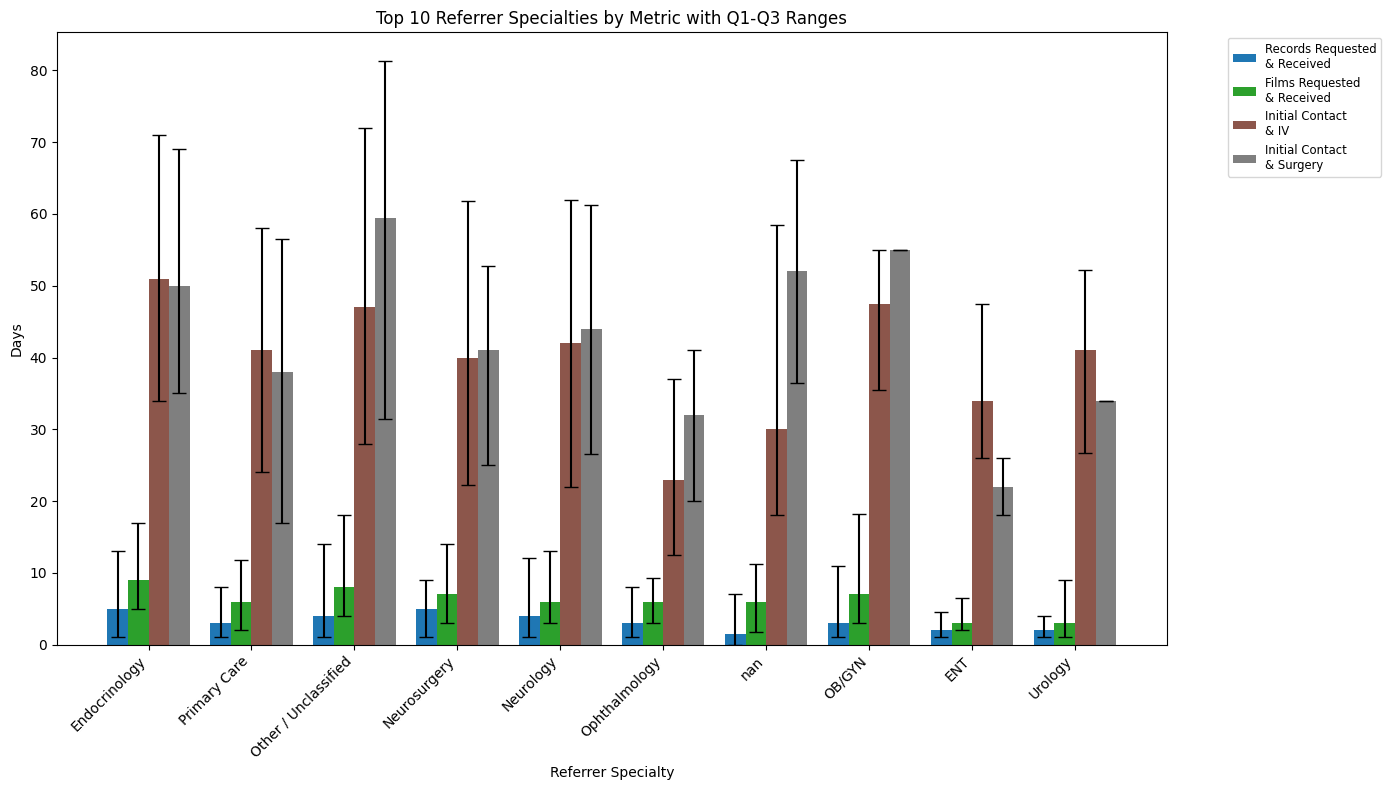

In [21]:
# Prepare the data for the top 10 specialties
top_10_specialties = referrers_spec_stats.head(10)

# Create an empty list to store the data
plot_data = []

# Metrics we are interested in
metrics = [
    "Days between Records Requested and Received",
    "Days between Films Requested and Received",
    "Days between Initial Contact and IV", 
    "Days between Initial Contact and Surgery"
]

# Prepare the data for plotting
for metric in metrics:
    for idx, row in top_10_specialties.iterrows():
        plot_data.append({
            "Referrer Specialty": row["Referrer Specialty"],
            "Metric": metric,
            "Median": row[f"{metric} Median"],
            "Q1": row[f"{metric} Q1"],
            "Q3": row[f"{metric} Q3"]
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(14, 8))

# Get unique metrics and specialties for proper positioning
unique_metrics = plot_df["Metric"].unique()
unique_specialties = plot_df["Referrer Specialty"].unique()
n_metrics = len(unique_metrics)
bar_width = 0.8 / n_metrics

# Plot bars and error bars for each metric
for i, metric in enumerate(unique_metrics):
    metric_data = plot_df[plot_df["Metric"] == metric]
    
    # Calculate x positions for this metric's bars
    x = np.arange(len(unique_specialties))
    bar_positions = x + (i * bar_width) - (bar_width * (n_metrics-1)/2)
    
    # Plot bars
    bars = plt.bar(bar_positions, 
                   metric_data["Median"],
                   width=bar_width,
                   label=metric.replace('Days between ', '').replace(' and', '\n&'),
                   color=plt.cm.tab10(i/n_metrics))
    
    # Add error bars using Q1 and Q3
    plt.errorbar(bar_positions,
                 metric_data["Median"],
                 yerr=[metric_data["Median"] - metric_data["Q1"],  # Distance from median to Q1
                      metric_data["Q3"] - metric_data["Median"]],  # Distance from median to Q3
                 fmt='none',
                 color='black',
                 capsize=5)

# Customize the plot
plt.xlabel("Referrer Specialty")
plt.ylabel("Days")
plt.title("Top 10 Referrer Specialties by Metric with Q1-Q3 Ranges")
plt.xticks(x, unique_specialties, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to prevent clipping
plt.tight_layout()

# Save to plots directory
plt.savefig(os.path.join("plots", "top_10_referrers_specialties.png"), dpi=300)

# Show the plot
plt.show()

Let's do the same significance testing as above.


Kruskal-Wallis test for Days between Records Requested and Received:
Groups: ['Endocrinology', 'Primary Care', 'Other / Unclassified', 'Neurosurgery', 'Neurology', 'Ophthalmology', 'nan', 'OB/GYN', 'ENT', 'Urology']
Kruskal-Wallis H = 63.881, p-value = 0.0000
Performing pairwise Mann-Whitney U tests for Days between Records Requested and Received...
Endocrinology vs Primary Care: U=477067.50, p=0.0000
Endocrinology vs Other / Unclassified: U=158340.50, p=0.3336
Endocrinology vs Neurosurgery: U=129962.00, p=0.2259
Endocrinology vs Neurology: U=98055.00, p=0.3013
Endocrinology vs Ophthalmology: U=37290.50, p=0.0335
Endocrinology vs nan: U=31282.50, p=0.0017
Endocrinology vs OB/GYN: U=29550.50, p=0.1308
Endocrinology vs ENT: U=17746.00, p=0.0065
Endocrinology vs Urology: U=19259.50, p=0.0048
Primary Care vs Other / Unclassified: U=79015.50, p=0.0012
Primary Care vs Neurosurgery: U=63285.50, p=0.0014
Primary Care vs Neurology: U=48269.50, p=0.0068
Primary Care vs Ophthalmology: U=18367.00

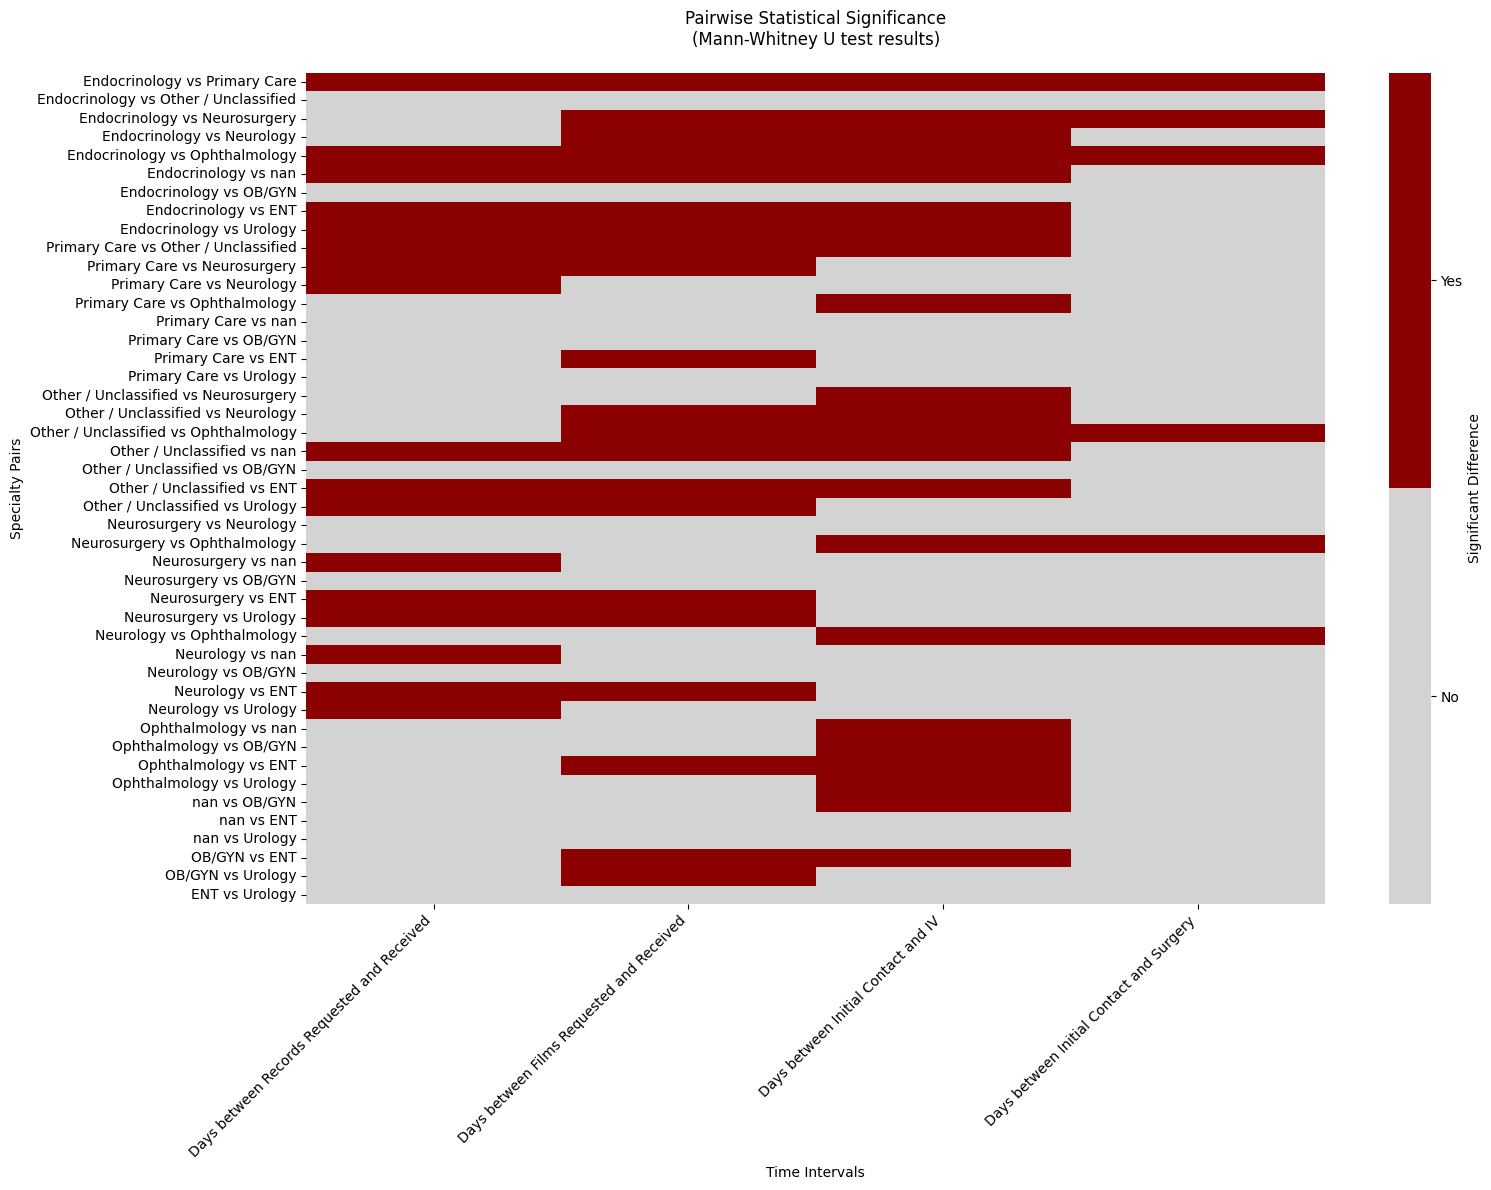

In [22]:
# Grouping column
group_col = "RP Specialty"
value_cols = [
    "Days between Records Requested and Received",
    "Days between Films Requested and Received",
    "Days between Initial Contact and IV",
    "Days between Initial Contact and Surgery"
]

# Prepare a dictionary to hold the results
results_dict = {}

# Iterate over value columns
for value_col in value_cols:
    # Fill NaNs in RP Spec with "nan" for grouping
    raw_ref_data[group_col] = raw_ref_data[group_col].fillna("nan")

    # Get data for each group
    groups = raw_ref_data[group_col].unique()
    # Limit groups to the top 10 by number of records
    top_groups = raw_ref_data[group_col].value_counts().nlargest(10).index.tolist()
    samples = [raw_ref_data[raw_ref_data[group_col] == g][value_col].dropna() for g in top_groups]

    # Run Kruskal-Wallis test
    stat, p = kruskal(*samples)

    # Store Kruskal-Wallis result
    results_dict[value_col] = {
        'kruskal_stat': stat,
        'kruskal_p': p,
        'pairwise_results': []
    }

    # Print Kruskal-Wallis test result
    print(f"\nKruskal-Wallis test for {value_col}:")
    print(f"Groups: {top_groups}")
    print(f"Kruskal-Wallis H = {stat:.3f}, p-value = {p:.4f}")

    # If Kruskal-Wallis is significant, perform pairwise Mann-Whitney U tests
    if p < 0.05:
        print(f"Performing pairwise Mann-Whitney U tests for {value_col}...")
        for g1, g2 in combinations(top_groups, 2):
            s1 = raw_ref_data[raw_ref_data[group_col] == g1][value_col].dropna()
            s2 = raw_ref_data[raw_ref_data[group_col] == g2][value_col].dropna()
            stat, p = mannwhitneyu(s1, s2, alternative="two-sided")
            results_dict[value_col]['pairwise_results'].append({
                'group1': g1,
                'group2': g2,
                'U': stat,
                'p': p
            })
            # Print Mann-Whitney U test result
            print(f"{g1} vs {g2}: U={stat:.2f}, p={p:.4f}")

# Create a dataframe to store pairwise significance results
pairwise_significance = {}

for value_col in value_cols:
    pairwise_significance[value_col] = {}
    for g1, g2 in combinations(top_groups, 2):
        # Extract pairwise results
        significant = False
        for result in results_dict[value_col]['pairwise_results']:
            if result['group1'] == g1 and result['group2'] == g2 and result['p'] < 0.05:
                significant = True
        pairwise_significance[value_col][f"{g1} vs {g2}"] = 1 if significant else 0

# Convert the dictionary to a dataframe for easy plotting
pairwise_df = pd.DataFrame(pairwise_significance)

# Create discrete colormap
discrete_colors = ['lightgray', 'darkred']
discrete_cmap = ListedColormap(discrete_colors)

# Create the heatmap with larger figure size
plt.figure(figsize=(16, 12))  # Increased from (12, 8)
heatmap = sns.heatmap(pairwise_df, 
            annot=False,  # Removed annotations
            cmap=discrete_cmap,
            cbar=True,
            cbar_kws={'label': 'Significant Difference'})

# Modify colorbar ticks and labels
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['No', 'Yes'])

# Customize the plot
plt.title("Pairwise Statistical Significance\n(Mann-Whitney U test results)", pad=20)
plt.ylabel("Specialty Pairs")
plt.xlabel("Time Intervals")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label clipping
plt.tight_layout()

# Save the heatmap
plt.savefig(os.path.join("plots", "pairwise_significance_heatmap.png"), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [23]:
# Compute grouped stats by Zip Code
referrers_zip_stats = raw_ref_data.groupby("Zip Code").agg(agg_funcs).reset_index()

# Flatten column names
referrers_zip_stats.columns = ['Zip Code'] + [
    f"{col} {stat.__name__.capitalize() if callable(stat) else stat.capitalize()}".strip()
    for col, stat in referrers_zip_stats.columns[1:]
]

# Round for readability
referrers_zip_stats = referrers_zip_stats.round(2)

# Add number of records per Zip Code
referrers_zip_stats["Number of Records"] = raw_ref_data.groupby("Zip Code").size().values

# Rename for clarity
referrers_zip_stats = referrers_zip_stats.rename(columns={"Zip Code": "Referrer Zip Code"})

# Sort by number of records
referrers_zip_stats = referrers_zip_stats.sort_values(by="Number of Records", ascending=False)

# Preview top results
referrers_zip_stats.head(20)

,Referrer Zip Code,Days between Records Requested and Received Median,Days between Records Requested and Received Q1,Days between Records Requested and Received Q3,Days between Records Requested and Received Iqr,Days between Films Requested and Received Median,Days between Films Requested and Received Q1,Days between Films Requested and Received Q3,Days between Films Requested and Received Iqr,Days between Initial Contact and IV Median,Days between Initial Contact and IV Q1,Days between Initial Contact and IV Q3,Days between Initial Contact and IV Iqr,Days between Initial Contact and Surgery Median,Days between Initial Contact and Surgery Q1,Days between Initial Contact and Surgery Q3,Days between Initial Contact and Surgery Iqr,Number of Records
1982,nan,5.0,2.00,12.00,10.00,7.0,4.00,14.25,10.25,44.0,29.50,62.50,33.00,46.5,26.00,73.25,47.25,239
524,22901,3.0,1.00,6.00,5.00,3.0,1.00,7.00,6.00,36.0,18.25,55.75,37.50,NaN,NaN,NaN,NaN,71
499,22801,1.0,0.00,2.00,2.00,1.0,0.00,3.00,3.00,31.0,21.00,48.75,27.75,NaN,NaN,NaN,NaN,51
833,24401,2.0,1.00,9.00,8.00,2.0,1.00,4.00,3.00,42.0,21.25,67.25,46.00,12.0,12.00,12.00,0.00,43
554,22980,6.5,1.00,10.25,9.25,4.0,1.00,6.50,5.50,27.5,15.75,44.75,29.00,NaN,NaN,NaN,NaN,40
526,22903,5.0,1.00,7.00,6.00,6.0,5.50,8.50,3.00,38.5,26.50,53.00,26.50,NaN,NaN,NaN,NaN,40
428,22407,3.5,1.00,8.00,7.00,6.0,3.50,11.00,7.50,40.5,26.00,54.25,28.25,47.0,43.75,58.75,15.00,38
479,22701,5.0,1.00,9.00,8.00,9.0,5.50,14.50,9.00,44.0,31.75,56.75,25.00,21.0,21.00,21.00,0.00,36
869,24502,2.0,1.00,3.00,2.00,6.0,2.00,7.00,5.00,43.0,22.00,67.00,45.00,82.0,82.00,82.00,0.00,35
228,20147,10.0,1.75,20.75,19.00,9.0,4.00,19.50,15.50,50.5,37.00,57.75,20.75,28.0,22.50,33.00,10.50,32


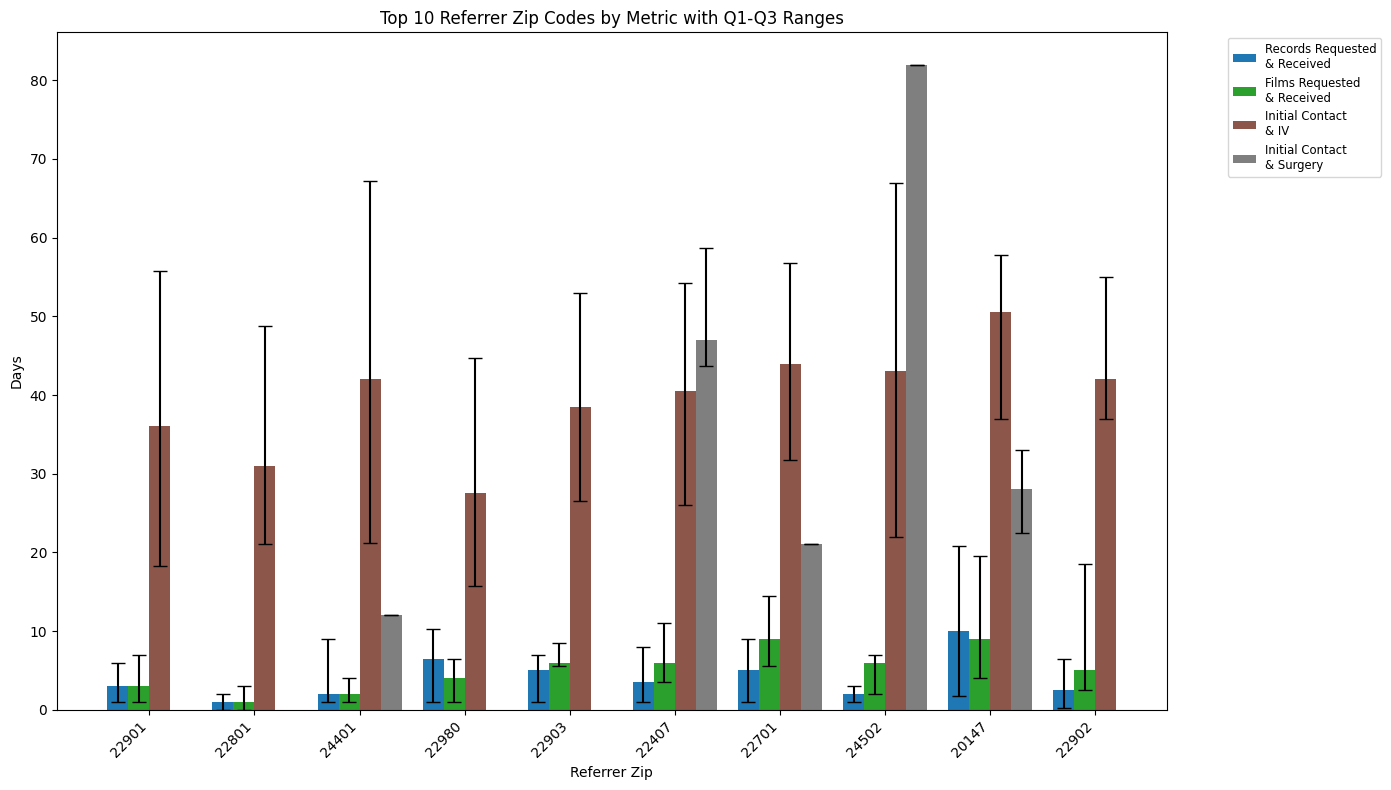

In [24]:
# Plot stats for the top 10 Zip Codes
# Prepare the data for the top 10 zips not including "nan"
top_10_zips = referrers_zip_stats[referrers_zip_stats["Referrer Zip Code"] != "nan"].head(10)

# Create an empty list to store the data
plot_data = []

# Metrics we are interested in
metrics = [
    "Days between Records Requested and Received",
    "Days between Films Requested and Received",
    "Days between Initial Contact and IV", 
    "Days between Initial Contact and Surgery"
]

# Prepare the data for plotting
for metric in metrics:
    for idx, row in top_10_zips.iterrows():
        plot_data.append({
            "Zip": row["Referrer Zip Code"],
            "Metric": metric,
            "Median": row[f"{metric} Median"],
            "Q1": row[f"{metric} Q1"],
            "Q3": row[f"{metric} Q3"]
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(14, 8))

# Get unique metrics and specialties for proper positioning
unique_metrics = plot_df["Metric"].unique()
unique_specialties = plot_df["Zip"].unique()
n_metrics = len(unique_metrics)
bar_width = 0.8 / n_metrics

# Plot bars and error bars for each metric
for i, metric in enumerate(unique_metrics):
    metric_data = plot_df[plot_df["Metric"] == metric]
    
    # Calculate x positions for this metric's bars
    x = np.arange(len(unique_specialties))
    bar_positions = x + (i * bar_width) - (bar_width * (n_metrics-1)/2)
    
    # Plot bars
    bars = plt.bar(bar_positions, 
                   metric_data["Median"],
                   width=bar_width,
                   label=metric.replace('Days between ', '').replace(' and', '\n&'),
                   color=plt.cm.tab10(i/n_metrics))
    
    # Add error bars using Q1 and Q3
    plt.errorbar(bar_positions,
                 metric_data["Median"],
                 yerr=[metric_data["Median"] - metric_data["Q1"],  # Distance from median to Q1
                      metric_data["Q3"] - metric_data["Median"]],  # Distance from median to Q3
                 fmt='none',
                 color='black',
                 capsize=5)

# Customize the plot
plt.xlabel("Referrer Zip")
plt.ylabel("Days")
plt.title("Top 10 Referrer Zip Codes by Metric with Q1-Q3 Ranges")
plt.xticks(x, unique_specialties, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to prevent clipping
plt.tight_layout()

# Save to plots directory
plt.savefig(os.path.join("plots", "top_10_referrers_zips.png"), dpi=300)

# Show the plot
plt.show()

In [25]:
# Could determine statistically significant differences but there is a lot going on here...lmk if you want me to look at anything specific

In [ ]:
columns_to_map = [
    "Days between Records Requested and Received Median",
    "Days between Films Requested and Received Median",
    "Days between Initial Contact and IV Median",
    "Days between Initial Contact and Surgery Median"
]

# Download the county boundaries
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# Load ZIP to county FIPS crosswalk data
us_zip_fips = pd.read_csv('data/uszips.csv', dtype={'zip': str, 'county_fips': str})


# Merge your zip stats with the FIPS crosswalk
plot_data = referrers_zip_stats.merge(
    us_zip_fips[['zip', 'county_fips']], 
    left_on='Referrer Zip Code', 
    right_on='zip', 
    how='left'
)


# Group by county FIPS (since multiple ZIPs can be in one county)
# Add sum of Number of Records to the aggregation
county_stats = plot_data.groupby('county_fips').agg({
    **{col: 'median' for col in columns_to_map},
    'Number of Records': 'sum'  # Add this line to get county-level counts
}).reset_index()


# Create choropleth maps for each metric
for col in columns_to_map:
    # Compute overall median
    metric_name = col.replace(" Median", "")
    overall_median = referrers_medians[metric_name]
    
    # Calculate difference from median
    county_stats[f"{col} Difference"] = county_stats[col] - overall_median
    
    # Create figure with hover data including counts
    fig = px.choropleth(
        county_stats,
        geojson=counties,
        locations='county_fips',
        color=f"{col} Difference",
        color_continuous_scale=["green", "white", "red"],
        range_color=[-30, 30],
        scope="usa",
        labels={
            f"{col} Difference": "Days +/- Median",
            col: "Median Days",
            "Number of Records": "Number of Referrals"  # Add label for counts
        },
        # Add count to hover data
        custom_data=["Number of Records"]
    )
    
    # Customize hover template to show count
    fig.update_traces(
        hovertemplate="<br>".join([
            "County FIPS: %{location}",
            "Difference from median: %{z:.1f} days",
            "Number of referrals: %{customdata[0]}"
        ])
    )

    
    # Update layout
    fig.update_layout(
        title=f"County Time Differences from Median:<br>{metric_name}<br>(hover for referral counts)",
        title_x=0.5,
        margin={"r":0,"t":50,"l":0,"b":0},
        height=800
    )
    
    # Zoom to Virginia area
    fig.update_geos(
        center=dict(lat=37.5, lon=-79),
        scope='usa',
        projection_scale=3
    )
    
    # Save and display
    fig.write_html(os.path.join("plots", f"{metric_name}_county_map.html"), include_plotlyjs='cdn')
    
    fig.show()

Creating map for: Days between Records Requested and Received Median
Geos updated successfully. Focus on VA area.


In [27]:
# Save all the cleaned data to a new CSV file
raw_ref_data.to_csv(os.path.join("output_data", "cleaned_ref_data.csv"), index=False, encoding="ISO-8859-1")
# Save all the stats to a new CSV file
referrers_degree_stats.to_csv(os.path.join("output_data", "referrers_degree_stats.csv"), index=False, encoding="ISO-8859-1")
# Save all the stats to a new CSV file
referrers_spec_stats.to_csv(os.path.join("output_data", "referrers_spec_stats.csv"), index=False, encoding="ISO-8859-1")
# Save all the stats to a new CSV file
referrers_zip_stats.to_csv(os.path.join("output_data", "referrers_zip_stats.csv"), index=False, encoding="ISO-8859-1")
